In [1]:
import os
import importlib
import re

import ase
from ase.visualize import view
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
import matplotlib.pyplot as plt

import ml_collections

from molnet import loss
from molnet.data import input_pipeline_online, input_pipeline_water, augmentation
from configs import root_dirs
from configs.tests import attention_test

2025-01-28 12:41:35.503075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [29]:
config = attention_test.get_config()
config.train_molecules = (0, 100000)
config.val_molecules = (100000, 120000)
config.rng_seed = 0
config.dataset = "afms_rebias"
config.root_dir = root_dirs.get_root_dir(config.dataset)
config.num_workers = 8
config.batch_size = 16
config.interpolate_input_z = 15
config.sigma = 0.2
config.target_z_cutoff = 1.5
config.noise_std = 0.2

In [31]:
tf.random.set_seed(config.rng_seed)
datasets = input_pipeline_online.get_datasets(config)
#datasets = input_pipeline_water.get_datasets(config)

ds = datasets['val']
batch = next(ds)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 18085879115725111131
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 15504905208096034983


In [32]:
batch = next(ds)
x = batch['images'][0]
y = batch['atom_map'][0]
xyz = batch['xyz'][0]
sw = batch['sw'][0]

print(xyz[:, -1])
print(x.shape, y.shape, xyz.shape)
print(f"ymin, ymax: {y.min()}, {y.max()}")
print(sw)
print(xyz)

[7. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
(128, 128, 15, 1) (128, 128, 15, 5) (54, 5)
ymin, ymax: 0.0, 0.9986076951026917
[[ 0.         0.         0.       ]
 [15.9       15.9        1.8999996]]
[[ 8.83167553e+00  6.39166069e+00 -5.88142276e-01 -1.62459999e-01
   7.00000000e+00]
 [ 1.06893711e+01  1.16424294e+01  2.72097731e+00 -1.55400001e-02
   6.00000000e+00]
 [ 4.20794821e+00  5.11585617e+00 -2.51885629e+00 -1.61600001e-02
   6.00000000e+00]
 [ 1.15014057e+01  1.05677643e+01  2.34397340e+00  6.95999991e-03
   6.00000000e+00]
 [ 5.25567245e+00  4.33561420e+00 -2.02169490e+00  1.50000001e-03
   6.00000000e+00]
 [ 4.27227497e+00  6.50824833e+00 -2.39503789e+00  3.86000006e-03
   6.00000000e+00]
 [ 8.80837154e+00  1.05633278e+01  1.63587856e+00 -2.32599992e-02
   6.00000000e+00]
 [ 1.09700832e+01  9.50102043e+00  1.61965549e+00 -2.48399992e-02
   6.00000000e+00]
 

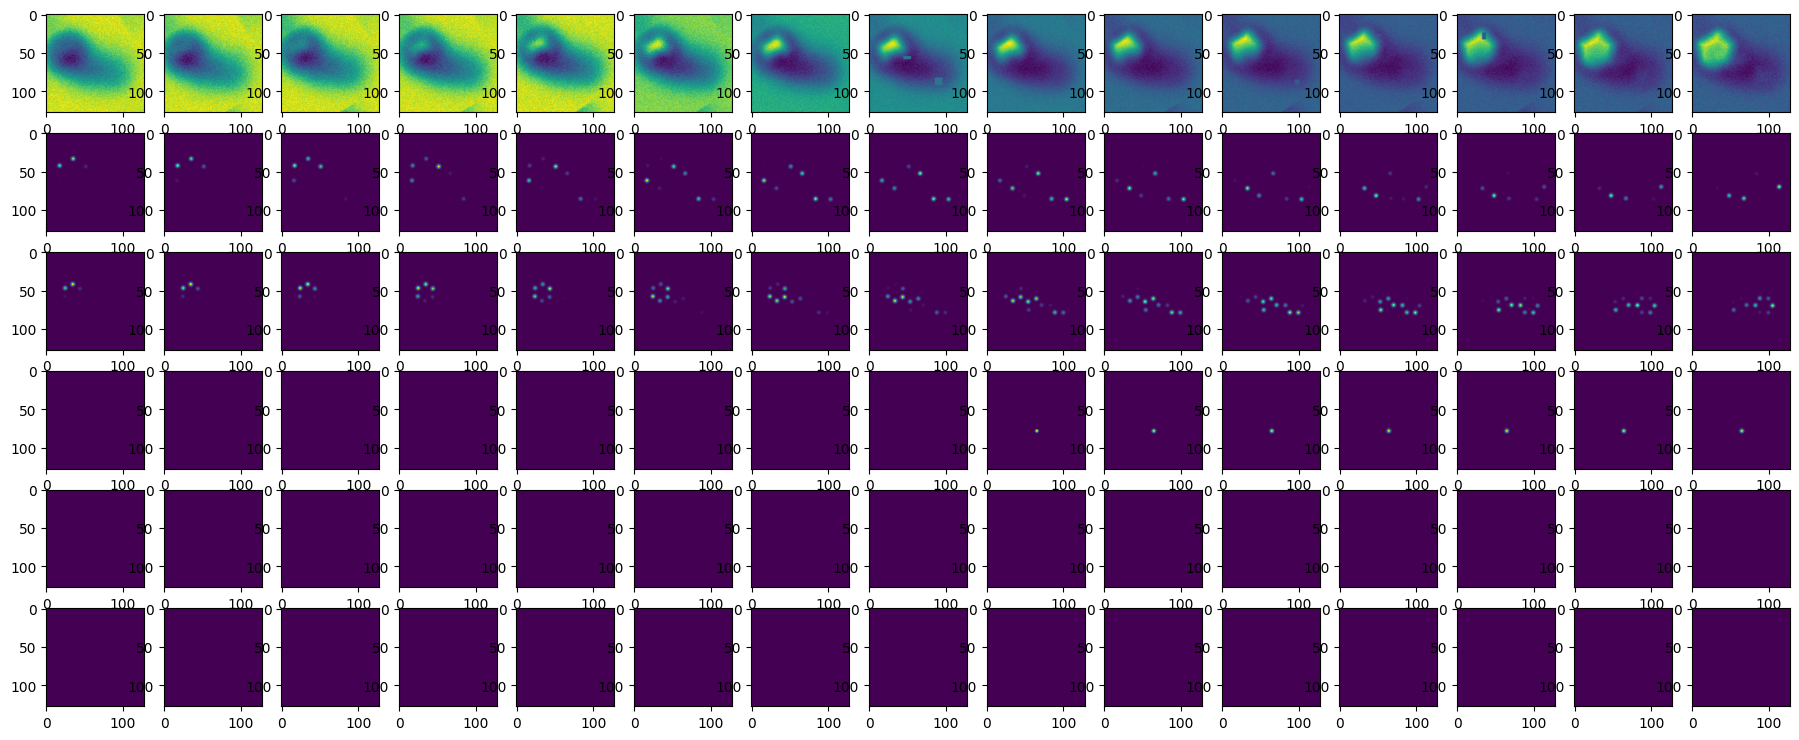

In [34]:
num_species = batch["atom_map"].shape[-1]
num_heights = batch["atom_map"].shape[-2]
index = 1

fig = plt.figure(figsize=(num_heights*1.5, (1+num_species)*1.5))
for i in range(num_heights):
    ax = plt.subplot(num_species+1, num_heights, i + 1)
    ax.imshow(batch["images"][index, :, :, i, 0])

    for j in range(num_species):
        ax = plt.subplot(num_species+1, num_heights, (j+1)*num_heights + i + 1)
        ax.imshow(batch["atom_map"][index, :, :, i, j])


In [12]:
mol = ase.Atoms(positions=xyz[:, :3], numbers=xyz[:, -1].astype(int))
pos = mol.positions

print(pos[pos[:, 2] > pos[:, 2].max()-2])
view(mol)

[[32.99258804 12.33116627 10.99443054]
 [28.01191711 17.38195229 11.61677933]
 [26.45428085 17.14998245 11.56280994]
 [27.31250954 11.81383038 12.28277969]
 [26.17712975 11.74825954 11.20481968]
 [27.84795761 15.26230145 11.13846016]
 [27.61957169 13.69179726 10.9460392 ]
 [32.14831161 15.91050816 11.26194   ]
 [33.15589142 14.76466465 10.8552599 ]
 [20.82154465 20.42584991 11.44701004]
 [32.57822037 19.66446304 12.00641918]
 [21.74497986 17.35976601 12.83918953]
 [21.61719894 18.22539711 11.54082012]
 [20.88920975 15.98948002 11.19225025]
 [20.65024567 14.44724846 11.24984932]
 [25.06917191 23.15203094 11.73678017]
 [26.29729652 22.56615829 10.92506981]
 [23.91353989 17.39862251 11.44973946]
 [24.52807808 18.69197464 10.85399914]
 [24.46287155  7.74236822 10.86551952]
 [31.08172226 17.75771332 11.68898964]
 [30.31004333 16.7449894  12.59955025]
 [27.309618   16.74855614 11.85236931]
 [26.80820084 12.36117744 11.65926075]
 [33.10172653 15.71727467 11.10476971]
 [21.26504517 19.80729675

<Popen: returncode: None args: ['/u/79/kurkil1/unix/.venvs/tf-2.13/bin/pytho...>

## Create "fake" webdataset for testing

In [ ]:
import webdataset as wds

In [ ]:
def generator(N=100):
    for i in range(N):
        sample = {
            "__key__": str(i*100),
            "label.cls": i*100,
        }
        yield sample

In [ ]:
temp_outputdir = "./temp/shard_1.tar"

os.makedirs(os.path.dirname(temp_outputdir), exist_ok=True)

gen = generator(100)
with wds.TarWriter(temp_outputdir) as sink:
    for sample in gen:
        sink.write(sample)

In [ ]:
shardlist = [
    os.path.join("./temp", shard) for shard in os.listdir("./temp")
]
ds = wds.DataPipeline(
    wds.SimpleShardList(shardlist),

    wds.shuffle(100),

    wds.tarfile_to_samples(),

    wds.shuffle(1000),

    wds.decode("l"),

    wds.to_tuple("__key__", "label.cls"),

    wds.batched(16)
)

In [ ]:
loader = iter(ds)
end_after_this_iteration = False

for i in range(1000):
    try:
        batch = next(loader)
    except StopIteration:
        if end_after_this_iteration:
            break
        print()

        loader = iter(ds)
        end_after_this_iteration = True
        continue

    print(batch[0])

['8900', '2100', '2000', '7300', '1', '6000', '6700', '400', '2800', '3', '1000', '12', '10', '7600', '2500', '27']
['3000', '6600', '22', '2300', '23', '31', '5600', '15', '24', '7700', '9100', '9', '7000', '18', '7800', '9500']
['1900', '46', '66', '3300', '62', '11', '72', '71', '36', '6800', '57', '33', '4600', '7', '4400', '8100']
['9800', '14', '8800', '5700', '1800', '3700', '47', '2600', '600', '6100', '2700', '21', '97', '43', '68', '7200']
['5800', '800', '3900', '8400', '80', '1600', '83', '51', '37', '7400', '6900', '1700', '4900', '87', '1300', '63']
['4300', '30', '9200', '2', '94', '9000', '8700', '95', '52', '7100', '2900', '38', '4', '300', '3600', '73']
['1200', '45', '6200', '100', '39', '49', '13', '4200', '65', '2200', '4500', '85', '5', '7900', '40', '8200']
['86', '9600', '61', '55', '4700', '89', '8600', '19', '76', '77', '3100', '75', '17', '48', '4000', '9900']
['6500', '5200', '8500', '4800', '29', '5900', '69', '34', '3200', '32', '58', '70', '7500', '0', '3

## test tf atom map computation

In [31]:
def compute_map(xyz, sigma=0.2):
    x = tf.linspace(tf.constant(0, dtype=tf.float32), 16, 128)
    y = tf.linspace(tf.constant(0, dtype=tf.float32), 16, 128)
    z = tf.range(14, 16, 0.1, dtype=tf.float32)

    X, Y, Z = tf.meshgrid(x, y, z, indexing='xy')

    # Compute atom maps.
    maps_h = tf.zeros_like(X)
    maps_c = tf.zeros_like(X)
    maps_n = tf.zeros_like(X)
    maps_o = tf.zeros_like(X)
    maps_f = tf.zeros_like(X)

    for atom in xyz:
        if atom[-1] == 1:
            maps_h += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )
        elif atom[-1] == 6:
            maps_c += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )
        elif atom[-1] == 7:
            maps_n += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )
        elif atom[-1] == 8:
            maps_o += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )
        elif atom[-1] == 9:
            maps_f += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )

    atom_map = tf.stack([maps_h, maps_c, maps_n, maps_o, maps_f], axis=0)
    atom_map = tf.transpose(atom_map, perm=[1, 2, 3, 0])
    return atom_map


In [32]:
xyz = tf.random.uniform((xyz.shape[0], 3), 0, 16)
species = tf.random.uniform(xyz.shape, 6, 10, dtype=tf.int32)
species = tf.cast(species, tf.float32)[:,0][..., None]
xyz = tf.concat([xyz, species], axis=-1)

m = compute_map(xyz)

(128, 128, 20, 5)


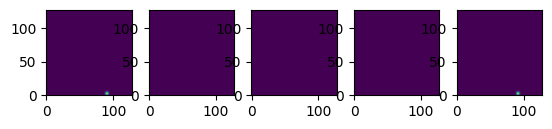

In [36]:
print(m.shape)

for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(m[..., -i, -1], origin='lower')

## data augmentation

In [2]:
def plot_stack(x):
    xmax = tf.reduce_max(x).numpy()
    fig, ax = plt.subplots(1, 5)
    for i in range(5):
        ax[i].imshow(x[..., i, 0], vmin=0, vmax=xmax)

In [6]:
x = np.arange(128)
y = np.arange(128)

x, y = np.meshgrid(x, y)
z = x + y
z = z[..., None]
z = np.tile(z, (1, 1, 5))

z2 = x * y
z2 = z2[None, ..., None]
z2 = np.tile(z2, (5, 1, 1, 20))

orig_batch = {
    "images": z,
    "atom_map": z2,
    "xyz": np.zeros((5, 20, 3)),
}

print(orig_batch['images'].shape)
print(orig_batch['atom_map'].shape)

(128, 128, 5)
(5, 128, 128, 20)


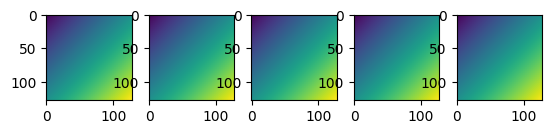

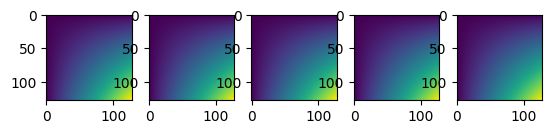

In [7]:
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(z[..., i])

fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(z2[i, ..., 0])

In [16]:
print(orig_batch['images'].shape)

batch = input_pipeline._preprocess_images(
    orig_batch,
    noise_std=0.1,
    interpolate_z=16,
    cutout_probs=[0.5, 0.3, 0.1, 0.05, 0.5],
)

print(orig_batch['images'].shape)

print(batch['images'].shape)
print(batch['atom_map'].shape)

(128, 128, 5)
(128, 128, 5)
(128, 128, 16, 1)
(128, 128, 16, 5)


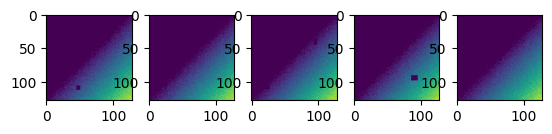

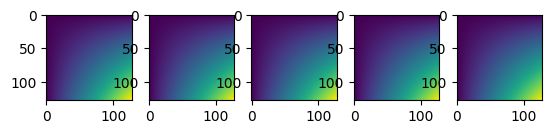

In [17]:
plot_stack(batch['images'])
plot_stack(batch['atom_map'])